In [1]:
# installed libraries
# +----------------------------------------------------------------------------+
import os
import sys
import glob
import matplotlib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ipywidgets import interact
from dataclasses import dataclass
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# local modules
# +----------------------------------------------------------------------------+    
from plotconf import matsettings
from magscales.magscales import Richter1958
from miscmeta.sta.uustacors import UUSJ

# ipython magick
# +----------------------------------------------------------------------------+
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Yellowstone National Park $M_L$ Magntiude Computation and Comparison
### A notebook to compute and compare $M_L$ for Yellowstone National Park. 

#### This notebook will cover two main analyses:
1. [Assign $M_L$ using the recovered distance and station corrections](#section_1) ([see that notebook](./YPMLNonParametricInversion.ipynb))
2. [Compare new with prior $M_L$ assignments from the University of Utah Seismograph Stations catalog](#section_2)
3. [Compute as many $M_L$ assignments as possible using a more complete p-p amplitude catalog, created using the automated picker method of [Koper *et al.* (2021)](https://doi.org/10.1785/0120200188
)](#section_3)


<a id=’section_1’></a> 
### Assign $M_L$ using recovered distance ($\mathrm{log_{10}} A_0$) and station corrections ($S_j$)

#### Load the base catalog and YPML distance and station corrections.

In [2]:
@dataclass(init=False)
class FileManager:
    cat_path: str
    model_path: str
    name: str
    cat: pd.DataFrame
    model: pd.DataFrame

session = FileManager()
@interact
def load_data(path=sorted(glob.glob("../catalogs/amplitudes/*clean.csv")), preview=['No', 'Yes']):
    tdf = pd.read_csv(path)
    print(f"loaded catalog {path.split('/')[-1]} ...")  
    session.cat = tdf.copy()
    session.cat_path = path
    if preview == 'Yes':
        return session.cat.head()

@interact
def load_model(path=sorted(glob.glob("../mlinversion/.model/*.json")), preview=['No', 'Yes']):
    tdf = pd.read_json(path)
    print(f"loaded model {path.split('/')[-1]} ...") 
    session.model = tdf.copy()
    session.model_path = path
    session.name = session.model_path.split("/")[-1].split(".")[0]
    if preview == 'Yes':
        return session.model

interactive(children=(Dropdown(description='path', options=('../catalogs/amplitudes/yellowstone.amps.clean.csv…

interactive(children=(Dropdown(description='path', options=('../mlinversion/.model/YPML-model-MLi-4-Sj-1.json'…

### This is where the fun begins ...

In [3]:
X, Y = session.model.loc["unique_labels", "logA0n"], session.model.loc["model_values", "logA0n"]
pd.DataFrame({"hypo. distance [km]":X, "-logA0":Y}).to_csv(f"../miscmeta/{session.name}-DIST-CORR.csv", index = False)
X, Y = session.model.loc["unique_labels", "Sj"], session.model.loc["model_values", "Sj"]
pd.DataFrame({"Sta.":X, "Sj":Y}).to_csv(f"../miscmeta/{session.name}-STA-CORR.csv", index = False)

In [4]:
# load Moment Tensor MW catalog
MT = pd.read_csv("../catalogs/events/MTCAT.csv")
r58 = Richter1958() # Richter 1958 (R58) logA0 ML correction (same as UUSS)
uusj = UUSJ().sj # Pechmann et al. (2007) - with some added later - UUSS station corrections
ccat = session.cat.copy() # chosen catalog

# ccat = ccat[ccat.Sta!="YTP"]
A = ccat.halfAmpH.copy() # amplitudes from catalog
rhyp = ccat.Rhyp.copy() # hypocentral distance from catalog
repi = ccat.Repi.copy() # epicentral distance from catalog 

# create dict for logA0 and sj to assist with merging values into catalog
dc = {"Rn-YP":np.array(session.model['logA0n'].loc['unique_labels']), 
      "LOGA0-YP": np.array(session.model['logA0n'].loc['model_values']),
      "Rn-R58": r58.distances,
      "LOGA0-R58": r58.logA0
     }
sj = {"Sta-YP": np.array([x.split(".")[1] for x in session.model["Sj"].loc['unique_labels']]),
      "Sj-YP": np.array(session.model["Sj"].loc['model_values']),
     }

# assign amplitudes and interpolate and assign appropriate logA0 corrections
ccat["LOGA"] = np.log10(A) 
ccat["LOGA0-YP"] = np.interp(rhyp, dc["Rn-YP"], dc["LOGA0-YP"]) # hypocentral distance for YPML
ccat["LOGA0-UUSS"] = np.interp(repi, dc["Rn-R58"], dc["LOGA0-R58"]) # epicentral distance for UUSS ML

## merge station corrections (Sj)
# merge YPML Sj
ccat = pd.merge(ccat, pd.DataFrame(sj), left_on="Sta", right_on="Sta-YP", how="outer").sort_values(["Evid", "Rhyp"]).reset_index(drop=True)
# merge UUSS Sj
ccat = pd.merge(ccat, uusj, left_on="Sta", right_on="Sta-UUSS", how="outer").sort_values(["Evid", "Rhyp"]).reset_index(drop=True)

for name in ["UUSS", "YP"]:
    
    # ML = Log10(A) - Log10(A0) + Sj
    # compute YP Station MLS
    ccat[f"Station-{name}ML"] = ccat["LOGA"] - ccat[f"LOGA0-{name}"]
    ccat[f"Station-{name}ML-S"] = ccat["LOGA"] - ccat[f"LOGA0-{name}"] + ccat[f"Sj-{name}"] 
    # compute the event mean ML for YP with and without Station correction
    ccat = ccat.merge(pd.DataFrame(ccat.groupby("Evid")[f"Station-{name}ML"].mean().rename(f"Event-Mean-{name}ML")), on='Evid', right_index=False)
    ccat = ccat.merge(pd.DataFrame(ccat.groupby("Evid")[f"Station-{name}ML"].median().rename(f"Event-Median-{name}ML")), on='Evid', right_index=False)
    ccat = ccat.merge(pd.DataFrame(ccat.groupby("Evid")[f"Station-{name}ML-S"].mean().rename(f"Event-Mean-{name}ML-S")), on='Evid', right_index=False)
    ccat = ccat.merge(pd.DataFrame(ccat.groupby("Evid")[f"Station-{name}ML-S"].median().rename(f"Event-Median-{name}ML-S")), on='Evid', right_index=False)


ccat = ccat.merge(MT[["Evid", "MwPref", "SLUMw", "UUSSMw"]], on='Evid', how='left', right_index=False)

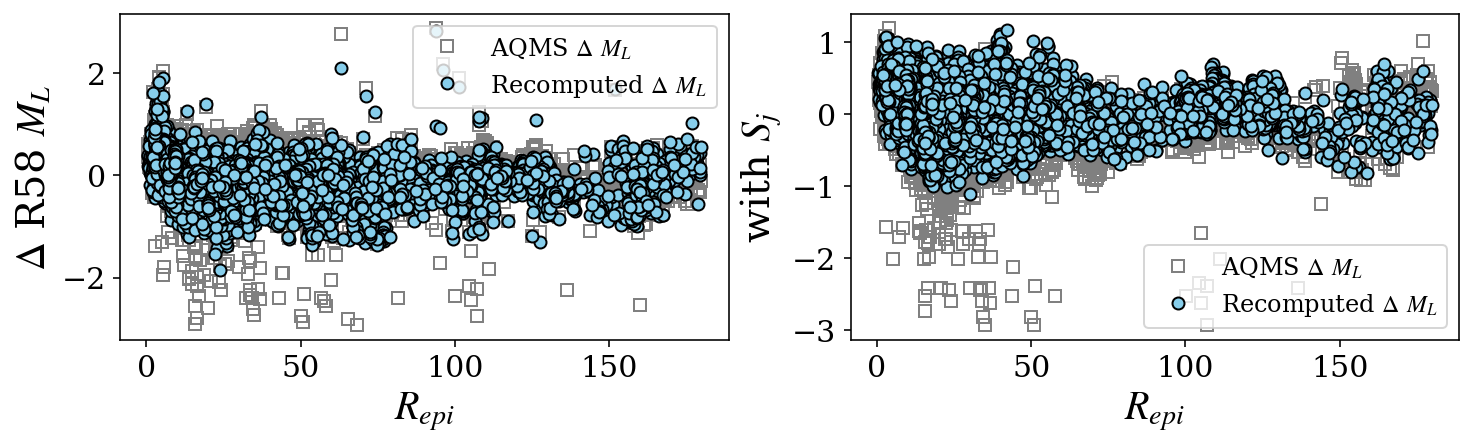

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(
    ccat["Repi"], 
    ccat["SML"] - ccat["EqML"], 
    's',
    color='grey',
    mfc='none', 
    label=r'AQMS $\Delta$ $M_L$'
    )
axes[0].plot(
    ccat["Repi"], 
    ccat["Station-UUSSML"] - ccat["Event-Mean-UUSSML-S"],
    'o',
    color='skyblue' ,
    mec='k',
    label = r'Recomputed $\Delta$ $M_L$',
    )
axes[1].plot(
    ccat["Repi"], 
    (ccat["SML"] - ccat["Sj-UUSS"]) - ccat["EqML"], 
    's',
    color='grey',
    mfc='none', 
    label=r'AQMS $\Delta$ $M_L$'
    )
axes[1].plot(
    ccat["Repi"], 
    ccat["Station-UUSSML-S"] - ccat["Event-Mean-UUSSML-S"], 
    'o', 
    color='skyblue', 
    mec='k',
    label = r'Recomputed $\Delta$ $M_L$'
    )

for ax in axes:
    ax.legend()
_ = axes[0].set(
    ylabel=r'$\Delta$ R58 $M_L$',
    xlabel=r'$R_{epi}$'
    )
_ = axes[1].set(
    ylabel=r'with $S_j$',
    xlabel=r'$R_{epi}$'
    )

In [6]:
@interact
def inspect_df(col1 = ccat.columns.values, col2=ccat.columns.values[1:]):
    tmp = ccat.copy(deep=True)
    return tmp[[col1, col2]].head()
    

interactive(children=(Dropdown(description='col1', options=('Evid', 'Date', 'Time', 'EqLat', 'EqLon', 'EqDep',…

#### Check that YP $M_L$ make sense.

interactive(children=(Dropdown(description='Sj', options=('ON', 'OFF'), value='ON'), Output()), _dom_classes=(…

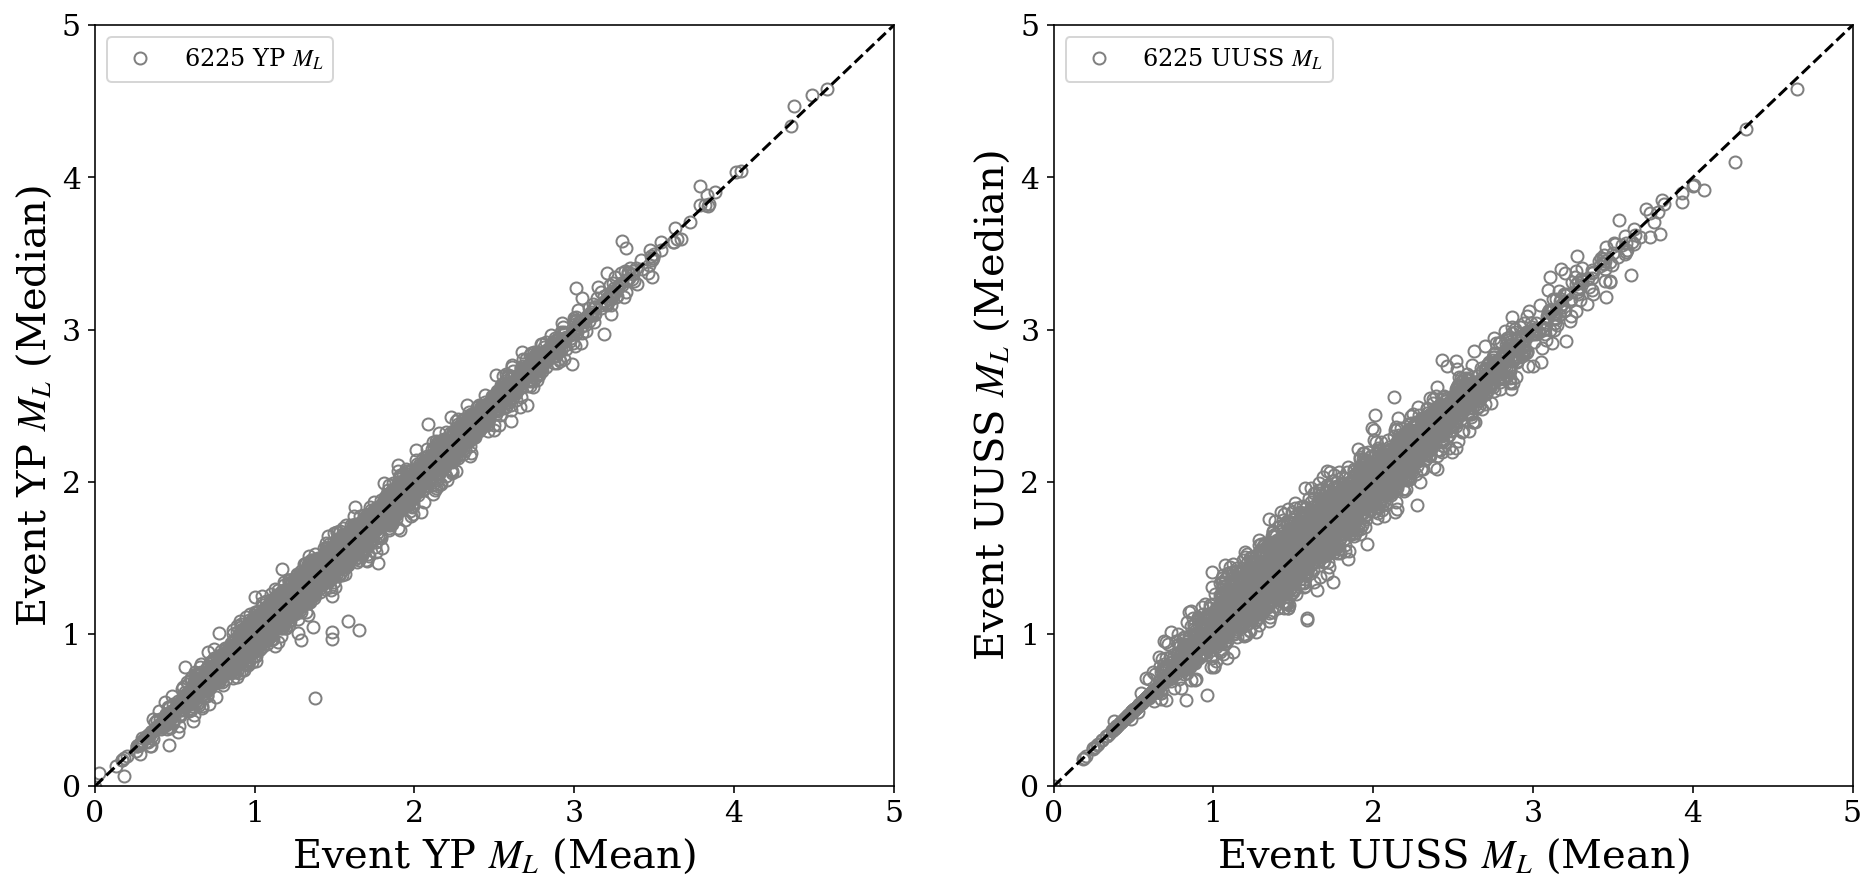

In [7]:
@interact
def inspect_mls(Sj=["ON", "OFF"]):
    s = ""
    if Sj == "ON":
        s = "-S"
    
    fig, axes = plt.subplots(1, 2, figsize=(7*2.25, 7))
    
    for i, name in enumerate(["YP", "UUSS"]):
        mn = f"Event-Mean-{name}ML"
        md = f"Event-Median-{name}ML"

        X = ccat.drop_duplicates("Evid")[f"{mn}{s}"].values
        Y = ccat.drop_duplicates("Evid")[f"{md}{s}"].values
        
        oo = np.arange(0, np.round(np.nanmax([X, Y])*1.1, 1)+0.1, 0.1)


        axes[i].plot(X, Y, 'o', color='grey', mfc='none', label=r"{} {} $M_L$".format(len(X), name))
        axes[i].plot(oo, oo, 'k--')
        axes[i].set_xlim([0, 5])
        axes[i].set_ylim([0, 5])
        axes[i].set_xlabel(r"Event {} $M_L$ (Mean)".format(name))
        axes[i].set_ylabel(r"Event {} $M_L$ (Median)".format(name))
        axes[i].legend()

<a id=’section_2’></a> 
### Compare $M_L$


In [8]:
@interact
def compare_with_r58(r58_dist=["Repi", "Rhyp"], mean_dep=(9, 11, 0.5)):
    plt.close()
    r58 = Richter1958()
    if r58_dist == "Rhyp":
        r58.epi_to_hypo(mean_dep)
    tmp = ccat.copy(deep=True)
    fig, ax = plt.subplots(2, 1, figsize=(7*1.25, 7*1.5), sharex=False)
    ax[0].plot(dc["Rn-YP"], dc["LOGA0-YP"], 'ks', mfc='none', label="YPML")
    ax[0].plot(r58.distances, r58.logA0, '^', label="R58")
    ax[0].set_xlabel(r"$R_{hyp}$ or $R_{epi}$")
    ax[0].set_ylabel(r"$\mathrm{log_{10} A_0}$")
    ax[0].set_xlim([-2, 182])
    ax[0].set_ylim([-4.2, -0.4])
    ax[0].legend()

    ax[1].plot(tmp['Rhyp'] - tmp['Repi'], (tmp["LOGA0-UUSS"] - tmp["LOGA0-YP"]), 'ko', mfc='none')#, c=tmp['Rhyp']-tmp['Repi'])
#     ax[1].scatter(tmp['Rhyp'], (tmp["LOGA0-R58"]-tmp["LOGA0-YP"]), c=tmp['Rhyp']-tmp['Repi'])
#     ax[1].hlines(0, r.min(), r.max(), color='k', zorder=0)
    ax[1].set_ylabel(r"$\Delta \mathrm{log_{10} A_0}$")
    ax[1].set_xlabel(r"$R_{hyp}$")
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='r58_dist', options=('Repi', 'Rhyp'), value='Repi'), FloatSlider(va…

#### Does the difference in distance metric account for the difference in $\mathrm{log_{10}A_0}$?

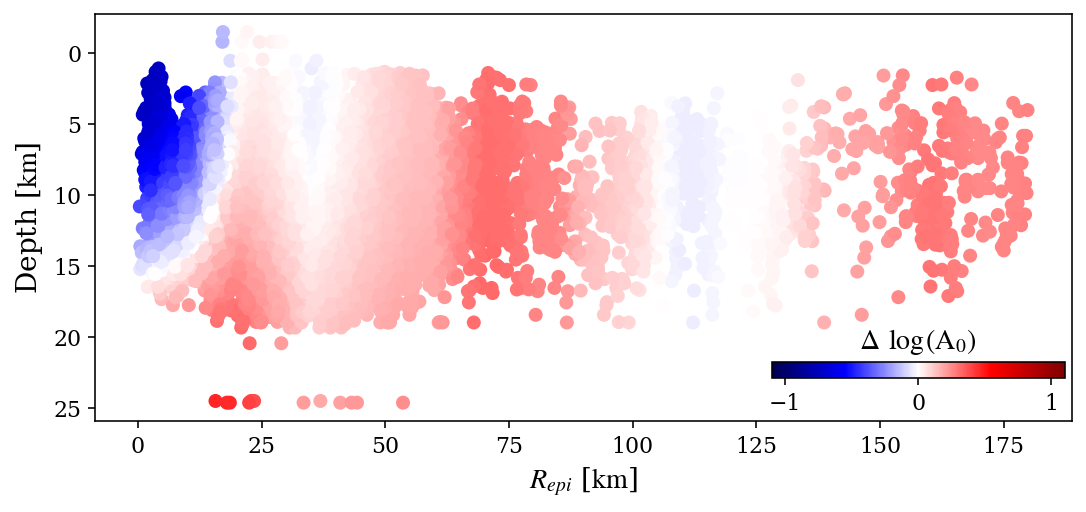

In [9]:
import matplotlib as mpl

fac = 1.25
fig, axes = plt.subplots(1, 1, figsize=(7*fac, 3*fac), sharex=True)
# out = axes[1].scatter(ccat['Rhyp'] - ccat['Repi'], ccat['EqDep'], c=ccat['Rhyp'])
# axes[1].invert_yaxis()
# cb = fig.colorbar(out, label=r"$R_{hyp}$ [$\mathrm{km}$]", ax=axes[1])

# axes[1].set_ylabel(r"Depth [$\mathrm{km}$]")
# cb.ax.invert_yaxis() 

out1 = axes.scatter(
    ccat['Repi'], 
    ccat['EqDep'], 
    c = ccat["LOGA0-UUSS"] - ccat["LOGA0-YP"], 
    cmap = 'seismic', 
    norm = mpl.colors.Normalize(vmin=-1.1, vmax=1.1)
)


# out1 = axes.scatter(
#     ccat['Rhyp'], 
#     ccat['EqDep'], 
#     c = ccat["LOGA0-UUSS"] - ccat["LOGA0-YP"], 
#     cmap = 'seismic', 
#     norm = mpl.colors.Normalize(vmin=-1.1, vmax=1.1)
# )
# axes.set_xlabel(r"$R_{hyp}$ [$\mathrm{km}$]")

cax = inset_axes(axes,
                 width="30%",  # width = 10% of parent_bbox width
                 height="4%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(0.69, 0.1, 1, 1),
                 bbox_transform=axes.transAxes,
                 borderpad=0.1,
                 )
cb1 = fig.colorbar(
    out1, 
    cax=cax,
    orientation='horizontal'
    )
cb1.set_label(
    r"$\Delta$ $\mathrm{log_{} (A_0)}$", 
    size=14,
    labelpad=7
    )
cb1.ax.tick_params(labelsize=11)
cb1.ax.xaxis.set_label_position("top")
# axes[1].set_xlabel(r"$R_{hyp} - R_{epi}$ [$\mathrm{km}$]")
axes.invert_yaxis()
axes.set_xlabel(r"$R_{epi}$ [$\mathrm{km}$]", fontsize=14)
axes.set_ylabel(r"Depth [$\mathrm{km}$]", fontsize=14)
axes.tick_params(axis='both', labelsize=11)

plt.subplots_adjust(hspace=0.1)

fig.savefig(f"../figures/LOGA0-DEP-DIST-DIFF-COMP-{session.name}.pdf", bbox_inches="tight")

In [10]:
def bin_data(Y, X, X_start, X_end, width):
    
    x = np.arange(X_start, X_end + width, width)
    
    bcs = x[:-1] + (width / 2)
    bmns = np.zeros(len(x[:-1]))
    bmds = bmns.copy()
    bstds = bmns.copy()
    blens = bmns.copy()
    
    for i in range(len(bcs)): 
        # specify bin edges
        bs, be = x[i], x[i+1] # bs is start, be is end
        bc = np.mean([bs, be]) # center of bins
        # cut bin values
        ycut = Y[(X > bs)&(X <= be)]
            
        # bin stats
        bmns[i] = np.nanmean(ycut)
        bmds[i] = np.nanmedian(ycut)
        bstds[i] = np.nanstd(ycut)
        blens[i] = len(ycut.notna())
        
    return bcs, bmns, bmds, bstds, blens

        

@interact
def inspect_mls(metric=["Mean", "Median"], 
                width=(0.1, 0.5, 0.05)
               ):
    plt.close()
    
    fac = 1.75
    
    smap = {"ON": "-S", "OFF": ""}
    
    fig, ax = plt.subplots(2, 2, 
                           figsize=(7*fac, 6*fac), 
                          )
    
    for i, Sj in enumerate(["OFF", "ON"]):
        
        s = smap[Sj]
        LIMS1 = [-0.1, 5.1]
        LIMS2 = [-1.25, 1.25]
        lsize = 16

        n = f"Event-{metric}-UUSSML"
        m = f"Event-{metric}-YPML"

        X = ccat.drop_duplicates("Evid")[f"{n}{s}"]
        Y = ccat.drop_duplicates("Evid")[f"{m}{s}"]
        resid = Y - X
        mean = np.mean(resid)
        std = np.std(resid)
        nfc = std/np.sqrt(len(resid[resid.notna()])-1)
    #     oo = np.arange(np.round(np.min([X, Y])/1.1, 1), np.round(np.max([X, Y])*1.1, 1)+0.1, 0.1)

        bx, by, bmd, bsv, blen = bin_data(Y, X, 0, 5, width)
        bdx, bdy, bdmd, bdsv, bdlen = bin_data(Y-X, X, 0, 5, width)

        ax[0, i].set_xlim(LIMS1)
        ax[0, i].set_ylim(LIMS1)
        ax[0, i].plot(X, Y, '.', color='#a6cee3', mfc='none')
        ax[0, i].plot(bx, by, 's', color='#33a02c', ms=14, mew=0.5, mec="black", zorder=10, label='bin Mean')
        ax[0, i].plot(bdx, bmd, 'wo', ms=7, mew=0.5, mec="black", zorder=11, label='bin Median')
        ax[0, i].errorbar(bx, by, bsv, ecolor='k', capsize=4, elinewidth=2, linestyle='', 
                          zorder=10, label='bin std. dev.')
        ax[0, i].plot(LIMS1, LIMS1, 'k--')
#         ax[0, i].set_xlabel(r"Event UUSS $M_L$")
        ax[0, i].tick_params(axis='x', labelsize=lsize)
        ax[0, i].tick_params(axis='y', labelsize=lsize)
        

        ax[1, i].plot(X, Y-X, '.', color='#a6cee3', mfc='none', zorder=0)
        ax[1, i].plot(bdx, bdy, 's', color='#33a02c', ms=10, mew=0.5, mec= "black", zorder=10)
        ax[1, i].plot(bdx, bdmd, 'wo', ms=4, mew=0.5, mec="black", zorder=11)
        ax[1, i].errorbar(bdx, bdy, bdsv, ecolor='k', capsize=4, elinewidth=2, linestyle='', zorder=10)
    #     ax[1].hlines(0, LIMS1[0], LIMS1[1], color='k', linestyles='dashed')
        ax[1, i].hlines(mean, LIMS1[0], LIMS1[1], color='k', label="Mean = {:.2f}".format(mean))
        ax[1, i].hlines(mean+std, LIMS1[0], LIMS1[1], color='k', linestyles='dashed', 
                     label=r"std. dev. = {:.2f}".format(std))
        ax[1, i].hlines(mean-std, LIMS1[0], LIMS1[1], color='k', linestyles='dashed')
        ax[1, i].set_xlabel(r"R58 $M_L$")
#         
        ax[1, i].tick_params(axis='x', labelsize=lsize)
        ax[1, i].tick_params(axis='y', labelsize=lsize)
        ax[1, i].legend()
        ax[i, 1].yaxis.tick_right()
        ax[0, i].xaxis.tick_top()
        ax[i, 1].text(0.8, 0.15, 
                      f"with {r'$S_j$'}", 
                      horizontalalignment='center', verticalalignment='center', 
                      transform=ax[i, 1].transAxes,
                      fontsize=20
                     )
        ax[1, i].set(xlim=LIMS1, ylim=LIMS2, aspect=1)
    
    ax[0, 0].legend()
#     ax[0, 0].set_ylabel(r"YP $M_L$ ({})".format(metric))
    ax[0, 0].set_ylabel(r"YP21 $M_L$")
    ax[1, 0].set_ylabel(r"$\Delta M_L$")
    ax[1, 0].set_xlabel(r"R58 $M_L$")
    plt.setp(ax[0, 0].get_xticklabels(), visible=False)
    plt.setp(ax[0, 1].get_yticklabels(), visible=False)
    plt.setp(ax[0, 1].get_xticklabels(), visible=False)
    plt.setp(ax[1, 1].get_yticklabels(), visible=False)
    fig.subplots_adjust(wspace=0.1, hspace=-0.2)
    fig.savefig(f"../figures/COMPARE-ML-{metric}-all-{session.name}.pdf", bbox_inches="tight")
    plt.show()


interactive(children=(Dropdown(description='metric', options=('Mean', 'Median'), value='Mean'), FloatSlider(va…

In [11]:
@interact
def inspect_mls(Sj=["ON", "OFF"], ML=["UUSS", "YP"], metric=["Mean", "Median"], Mw=["MwPref", "SLUMw", "UUSSMw"]):
    plt.close()
    s = ""
    if Sj == "ON":
        s = "-S"
    
    LIMS1 = [2.5, 5.1]
    LIMS2 = [-2, 2]
    
    local = f"Event-{metric}-{ML}ML{s}"

        
    X = ccat.drop_duplicates("Evid")[Mw]
    Y = ccat.drop_duplicates("Evid")[local]
    resid = Y-X
    mean = np.mean(resid)
    std = np.std(resid)
    nfc = std/np.sqrt(len(resid[resid.notna()])-1)
#     oo = np.arange(np.round(np.min([X, Y])/1.1, 1), np.round(np.max([X, Y])*1.1, 1)+0.1, 0.1)
    
    fig, ax = plt.subplots(1, 2, figsize=(7*2.25, 7))
    
    ax[0].set_xlim(LIMS1)
    ax[0].set_ylim(LIMS1)
    ax[0].plot(Y, X, 'o', color='grey', mfc='none', label=r"$M_L$")
    ax[0].plot(LIMS1, LIMS1, 'k--')
    ax[0].set_ylabel(r"{}".format(Mw))
    ax[0].set_xlabel(r"Event {} $M_L$ ({})".format(ML, metric))
    ax[0].legend()
    
    ax[1].set_xlim(LIMS1)
    ax[1].set_ylim(LIMS2)
    ax[1].plot(X, resid, 'o', color='grey', mfc='none', label=r"$\Delta M_L$")
    ax[1].hlines(0, LIMS1[0], LIMS1[1], color='k', linestyles='dashed')
    ax[1].hlines(mean, LIMS1[0], LIMS1[1], color='r', label="Mean={:.2f}".format(mean))
    ax[1].hlines(mean+nfc, LIMS1[0], LIMS1[1], color='r', linestyles='dashed', 
                 label=r"2*SE={:.2f}".format(nfc))
    ax[1].hlines(mean-nfc, LIMS1[0], LIMS1[1], color='r', linestyles='dashed')
    ax[1].set_xlabel("{}".format(Mw))
    ax[1].set_ylabel(f"{r'$M_L$'} - {Mw}")
    ax[1].legend()
    plt.show()

interactive(children=(Dropdown(description='Sj', options=('ON', 'OFF'), value='ON'), Dropdown(description='ML'…

In [12]:
def mdist_uncertainty(evml, sml):
    
    mdiff = evml - sml
    
    mse = np.nanmean(mdiff**2)
    mean = np.nanmean(mdiff)
    median = np.nanmedian(mdiff)
    std = np.nanstd(mdiff)
    nf_conf = 2*std/np.sqrt(len(mdiff))
    
    return mse, mean, median, std, nf_conf

def plot_block(ax, dist, sml, evml, width=10):
    
#     props = dict(boxstyle='round', facecolor='white')
    props = dict(facecolor='white')
    
    mse, mean, median, std, nf_conf = mdist_uncertainty(evml, sml)
    bx, by, bmd, bsd, blen = bin_data(
        sml - evml, 
        dist, 
        0, 
        180, 
        width
        )
    print(blen)
    # station (sml) minus event (evml) 
    ax.plot(dist, sml - evml, '.', color='#a6cee3', mfc='none')
    ax.plot(bx, by, 's', color='#33a02c', ms=12, mew=0.5, mec="black", zorder=10, label='bin Mean')
    ax.plot(bx, bmd, 'wo', ms=6, mew=0.5, mec="black", zorder=11, label='bin Median')
    ax.errorbar(bx, by, yerr=bsd, ecolor='k', capsize=4, 
                elinewidth=2, linestyle='', zorder=10, 
               label='bin std. dev.')
    ax.hlines(mean, dist.min(), dist.max(), 'k', zorder=11)
#     ax.hlines(mean-std, dist.min(), dist.max(), 'r', zorder=10)
#     ax.hlines(mean+std, dist.min(), dist.max(), 'r', zorder=10)
    ax.hlines(mean-std, dist.min(), dist.max(), 'k', linestyles='dashed', zorder=10)
    ax.hlines(mean+std, dist.min(), dist.max(), 'k', linestyles='dashed', zorder=10)    
    
#     ax.text(0.99, 0.95, f"MSE = {mse:.3f}", horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes, bbox=props)
#     ax.text(0.99, 0.88, f"Mean = {mean:.3f}", horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes, bbox=props)
#     ax.text(0.99, 0.81, f"Median = {median:.3f}", horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes, bbox=props)
#     ax.text(0.99, 0.74, f"st.dev. = {std:.3f}", horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes, bbox=props)

    ax.text(0.97, 0.83, 
        f"MSE = {mse:.2f}\nMean = {mean:.2f}\nMedian = {median:.2f}\nstd.dev. = {std:.2f}", horizontalalignment='right',
        verticalalignment='center', transform=ax.transAxes, bbox=props, fontsize=14)

#     ax.legend()
    ax.set_ylim([-1.5, 2])
    ax.set_xlim([-5, 185])



@interact
def plot_mdist(metric=["Mean", "Median"]):
    tmpp = ccat.copy(deep=True)
    plt.close()
    fac = 1.25
    fig, axes = plt.subplots(2, 2, figsize=(11*fac, 8*fac), sharex=True, sharey=True)
    axes = axes.flatten()
    for name, dist, ax in zip(["YP", "UUSS"], ["Rhyp", "Repi"], [axes[:2], axes[2:]]):
        
        plot_block(ax[0], tmpp[dist], tmpp[f"Station-{name}ML"], tmpp[f"Event-{metric}-{name}ML"])
        plot_block(ax[1], tmpp[dist], tmpp[f"Station-{name}ML-S"], tmpp[f"Event-{metric}-{name}ML-S"])
    
    # plot centre lines
    for ax1, ax2 in zip(axes.flatten()[:2], axes.flatten()[2:]):
        ax1.hlines(0, tmpp["Rhyp"].min(), tmpp["Rhyp"].max(), color='k', lw=2, zorder=10)
        ax2.hlines(0, tmpp["Repi"].min(), tmpp["Repi"].max(), color='k', lw=2, zorder=10)
        
    axes[0].set_ylabel(r"$\Delta$ YP21 $M_L$")
#     axes[1].set_ylabel(r"$\Delta$ YP $M_L$ w/ $S_j$")
    axes[2].set_ylabel(r"$\Delta$ R58 $M_L$")
    axes[0].set_xlabel(r"$R_{hyp}$ $\mathrm{[km]}$")
    axes[1].set_xlabel(r"$R_{hyp}$ $\mathrm{[km]}$")
    axes[2].set_xlabel(r"$R_{epi}$ $\mathrm{[km]}$")
    axes[3].set_xlabel(r"$R_{epi}$ $\mathrm{[km]}$")
    axes[0].legend(loc='upper left')
    
    axes[1].text(0.9, 
               0.05, 
               f"with {r'$S_j$'}", 
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[1].transAxes,
               fontsize=18
              )
    axes[3].text(0.9, 
               0.05, 
               f"with {r'$S_j$'}", 
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=axes[3].transAxes,
               fontsize=18
              )
    for ax in axes:
        ax.tick_params(axis='both', labelsize=16)
    
    plt.subplots_adjust(wspace=0.15, hspace=0.2)
    plt.show()
    fig.savefig(f"../figures/MAG-DIST-COMP-{metric}-EVML-{session.name}.pdf", bbox_inches="tight")

interactive(children=(Dropdown(description='metric', options=('Mean', 'Median'), value='Mean'), Output()), _do…

### How is $M_L$ impacted by having more $S_j$ for YP $M_L$ vs UUSS $M_L$
The UUSS do not use an $M_L$ if it has less than two station estimates. We test here to see how impactful it might be to have additional station corrections.  We see that a higher proportion of event mean $M_L$ have more station estimates when using YP $M_L$ station corrections.

In [13]:
def how_many_mls(name, nsta):
    tmp = ccat.copy(deep=True)
    x = tmp[tmp[f"Station-{name}ML-S"].notna()]
    g = x.groupby("Evid")[f"Station-{name}ML-S"]

    return list(range(1, nsta)), [len(tmp.iloc[g.filter(lambda x: len(x)>=n).index]\
        .groupby("Evid")[f"Station-{name}ML-S"]\
            .mean()\
                .rename(f"Event-Mean-{name}ML")) for n in range(1, nsta)]

min_sta_uu, num_ml_uu = how_many_mls("UUSS", 10)
min_sta_yp, num_ml_yp = how_many_mls("YP", 10)


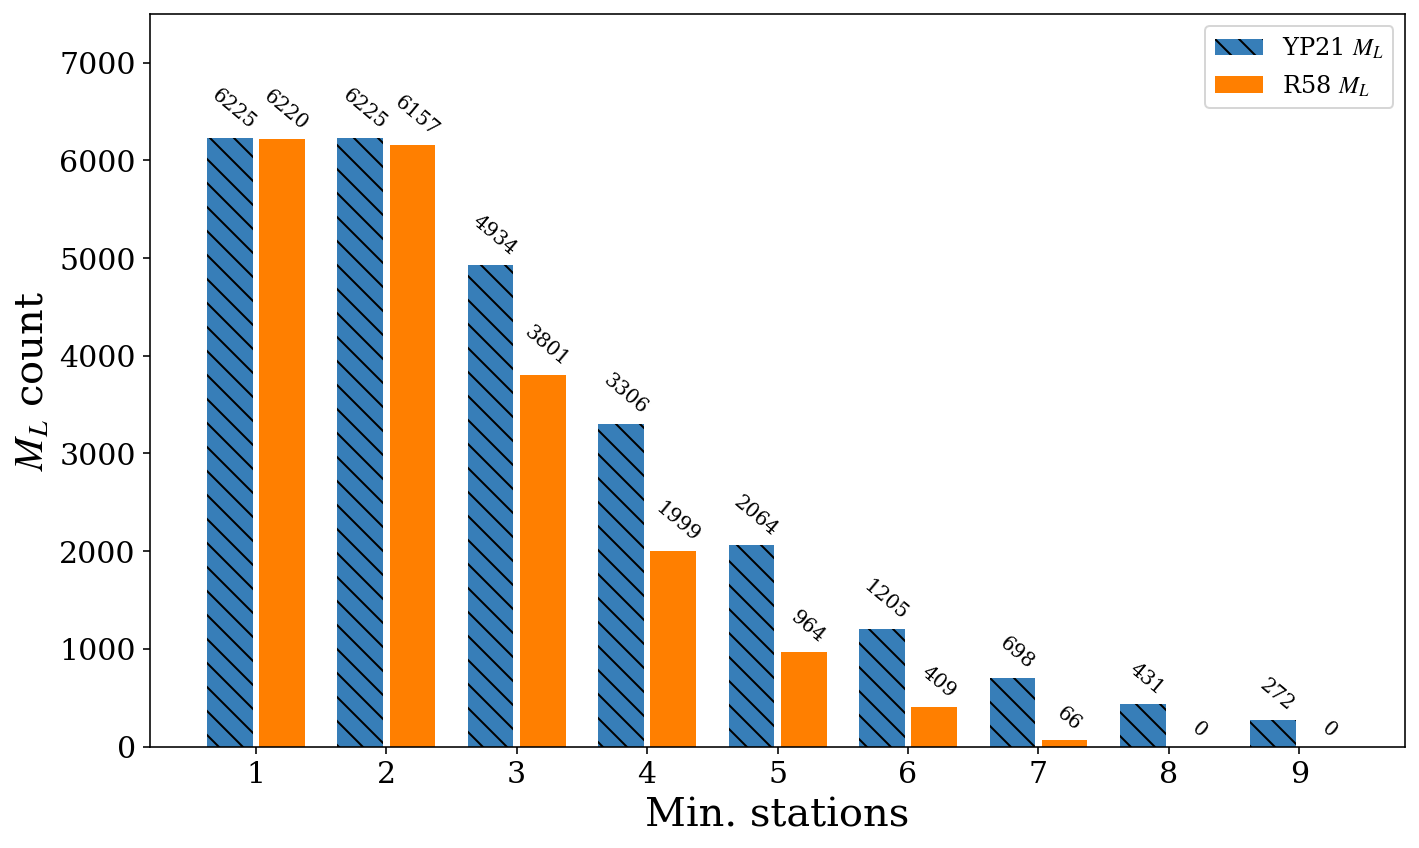

In [14]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(2, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=-40)



fig, ax = plt.subplots(figsize=(10, 6))

labels = min_sta_uu

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/1.75, num_ml_yp, width, 
                color='#377eb8', label=r"YP21 $M_L$",
                hatch="\\\\")
                
rects2 = ax.bar(x + width/1.75, num_ml_uu, width, 
                color='#ff7f00', label=r"R58 $M_L$")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Min. stations")
ax.set_ylabel("$M_L$ count")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 7500])
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig(f"../figures/EXTRA-SJ-FIG-{session.name}.pdf", bbox_inches="tight")

### How do YP $M_L$ and UUSS $M_L$ compare to $M_w$
<p>Here, we compute <b>UUSS</b> $M_L$ and <b>YP</b> $M_L$ in exactly the same way, using the same amplitudes to see how they compare with existing $M_w$ of the same events in the region.
The first is an interactive visualisation, so we can break down how the station $M_L$ compare to the mean $M_L$ and the $M_w$ assingment. We prefer UUSS $M_w$ over Saint Louis University's $M_w$ if we have one.</p>

In [15]:
@interact
def ev_hist(ev = MT.Evid.values, sj=["ON", "OFF"]):
    plt.close()
    if sj == "ON":
        s = "-S"
    else:
        s = ""
    tmp = ccat[ccat["Evid"] == ev]
    fig, ax = plt.subplots(1,1, figsize=(7, 5))
    ax.hist(tmp[f"Station-UUSSML{s}"], label=f"UUSS {r'$M_L$'}={tmp[f'Event-Mean-UUSSML{s}'].iloc[0]:.2f}")
    ax.hist(tmp[f"Station-YPML{s}"], label=f"YP {r'$M_L$'}={tmp[f'Event-Mean-YPML{s}'].iloc[0]:.2f}")
    ax.text(0.5, 0.5, f"{r'$M_w$'}={MT[MT['Evid']==ev]['MwPref'].values[0]}", 
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.legend()
    plt.show()

interactive(children=(Dropdown(description='ev', options=(50212935, 50277270, 50315205, 50357770, 50396715, 50…

### $M_w$ vs <b>YP</b> and <b>UUSS</b> $M_L$ continued ...
<p>In this section we compare the $M_L - M_w$ differences for <b>UUSS</b> and <b>YP</b> $M_L$. We noted that station $M_L$ can sometimes be very different from the mean. Therefore, for this analysis we trim the mean by removing station $M_L > 2.5 \sigma$ from the mean (aka. event) $M_L$. This is designed to be similar to UUSS routine procedures.</p>. 

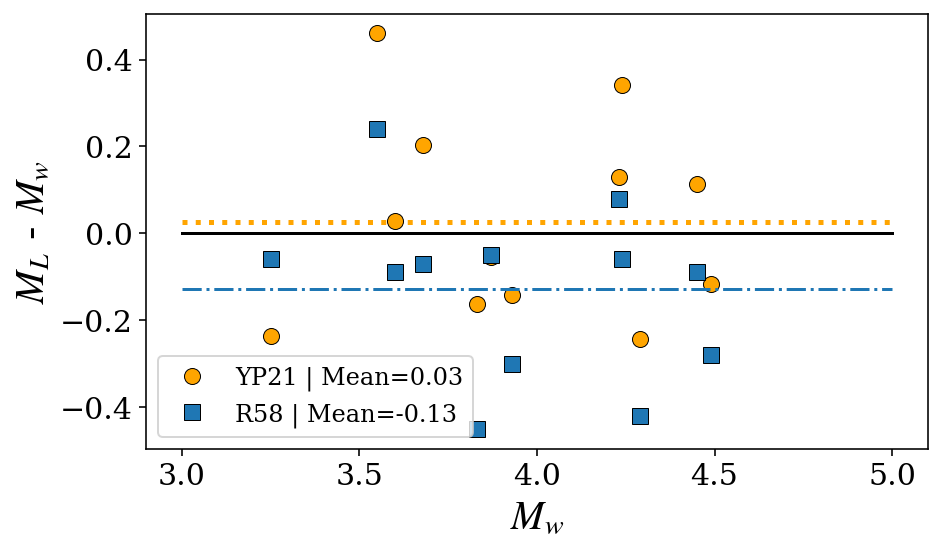

In [16]:
# Load the catalog of events with Mw obtained from time-domain moment tensor inversion.
# -------------------------------------------------------------------------------------
tmp = ccat[ccat["Evid"].isin(MT["Evid"])]

# We assign event YP and UUSS ML from the 'trimmed' mean ...
# (station ML < 2.5 std. dev.)
# ----------------------------------------------------------
curated={"Evid":[], "Event-Mean-YPML-S":[], "N":[]}
for ev in tmp.Evid.unique():
    
    g = tmp[tmp.Evid==ev].copy()
    
    nm = g[
        np.abs(
            g["Station-YPML-S"] - g["Station-YPML-S"].mean()
        ) <= 2.5*g["Station-YPML-S"].std()
    ]["Station-YPML-S"]
    
    m = nm.mean()
    l = len(nm)
    
    curated["Evid"].append(ev)
    curated["Event-Mean-YPML-S"].append(m)
    curated["N"].append(l)

# merge the the MT Mw table with the trimmed YP ML
# ------------------------------------------------
comp = pd.merge(
    MT.drop_duplicates("Evid")[
        ["Evid", "UUSSML", "MwPref", "UUSSMw"]
    ], 
    pd.DataFrame(curated), # convert dict to DataFrame to make it easier
    on='Evid'
)
# compute the mean differences between Mw and YP / UUSS ML
# --------------------------------------------------------
myp = np.mean(comp["Event-Mean-YPML-S"] - comp["MwPref"])
muu = np.mean(comp["UUSSML"] - comp["MwPref"])

# build the figure
# ----------------
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot([3, 5], [0, 0], 'k')
ax.plot(comp["MwPref"], comp["Event-Mean-YPML-S"]-comp["MwPref"], 
        'o', ms=8, mec='k', mew=0.5, color='orange', label=f"YP21 | Mean={myp:.2f}")
ax.plot([3, 5], np.array([0, 0])+myp, ':', lw=2.5, color="orange")
ax.plot(comp["MwPref"], comp["UUSSML"]-comp["MwPref"], 
        's', ms=8, mec='k', mew=0.5, color='C0', label=f"R58 | Mean={muu:.2f}")
ax.plot([3, 5], np.array([0, 0])+muu, '-.', lw=1.5, color="C0")
# figure styling
ax.set_ylabel(r"$M_L$ - $M_w$")
ax.set_xlabel(r"$M_w$")
ax.legend()
# save figure to PDF
fig.savefig(f"../figures/ML-MW-DIFFS-{session.name}.pdf", bbox_inches="tight")


In [21]:
comp

,Evid,UUSSML,MwPref,UUSSMw,Event-Mean-YPML-S,N
0,50212935,4.21,4.49,NaN,4.372739,3
1,50277270,4.31,4.23,NaN,4.359826,4
2,50315205,3.82,3.87,NaN,3.816499,2
3,50357770,4.18,4.24,NaN,4.581746,4
4,50396715,3.63,3.93,NaN,3.787942,3
5,50398395,3.87,4.29,NaN,4.046629,3
6,50443920,3.19,3.25,3.25,3.012865,9
7,50443120,3.51,3.60,3.60,3.627278,10
8,60026297,3.79,3.55,NaN,4.009971,7
9,60071202,3.38,3.83,NaN,3.668233,9


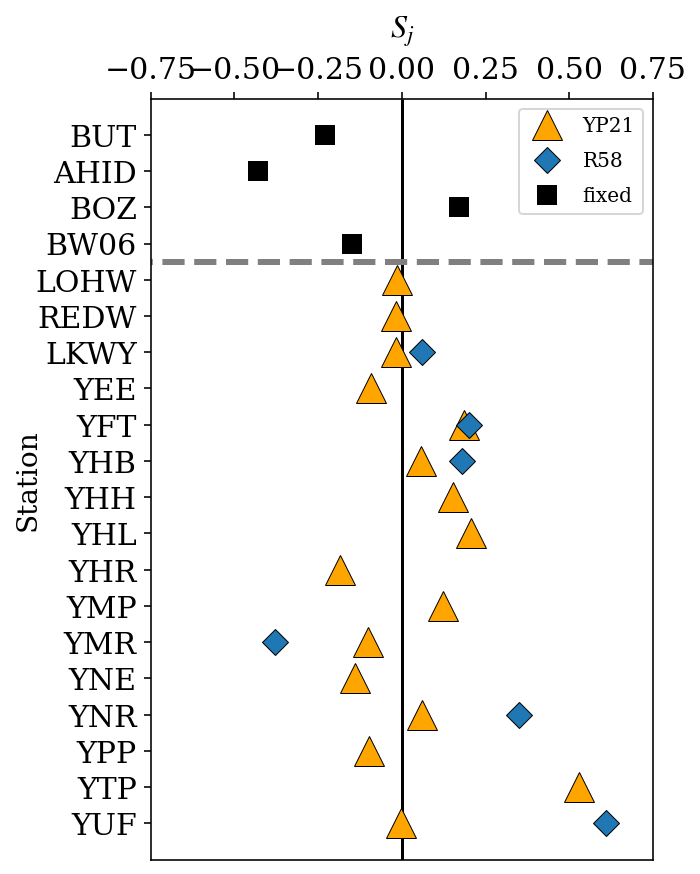

In [17]:
# Pull the unique station corrections for both YP and UUSS for plotting.
# ----------------------------------------------------------------------
stacomp = ccat.drop_duplicates("Sta")[["Net", "Sta", "Sj-YP", "Sj-UUSS"]]
stacomp["SEED"] = stacomp["Net"]+"."+stacomp["Sta"] # prefer to have NET.STA format
stacomp.sort_values("SEED", ascending=False, inplace=True) # sort them alphabetically
# for figure styling we want to plot the fixed corrections at the top so ...
# separating out where they are in the table will help do this. 
stacomp1 = stacomp[~stacomp["Sta"].isin(["BUT", "AHID", "BOZ", "BW06"])]
stacomp2 = stacomp[stacomp["Sta"].isin(["BUT", "AHID", "BOZ", "BW06"])]

# build the figure
# ----------------
fig, ax = plt.subplots(1,1, figsize=(4.5, 7))
# figure elements
ax.plot(stacomp1["Sj-YP"], stacomp1["Sta"], '^', color='orange', ms=15, mew=0.5, mec='black', label="YP21")
ax.plot(stacomp1["Sj-UUSS"], stacomp1["Sta"], 'D', color='C0', ms=9, mew=0.5, mec='black', label="R58")
# ax.plot(stacomp1["Sj-UUSS"]-stacomp1["Sj-YP"], stacomp1["SEED"], 'wX', ms=10, mec='k', mew=1, label=r'$\Delta S_j$')
ax.plot(stacomp2["Sj-UUSS"], stacomp2["Sta"], 'ks', label='fixed', ms=9)
ax.vlines(0, -1, len(stacomp), color='k')
ax.hlines(20-4.5, -1, 1, color='grey', linestyles='dashed', linewidth=3)
# various figure labels and styling
ax.set_ylabel("Station", labelpad=-3, fontsize=14)
ax.set_xlabel(r"$S_j$", labelpad=10, fontsize=16)
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-1, len(stacomp)])
# ax.tick_params(axis='x', labelrotation = 90)
ax.set_xticks(np.arange(-0.75, 1, 0.25))
ax.legend(fontsize=10, labelspacing=0.8)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top') 
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=11)
# save the figure to a PDF file.
fig.savefig(f"../figures/STA-CORR-COMP-{session.name}.pdf", bbox_inches="tight")

### Compute YP$M_L$ using auto picked amplitudes for Yellowstone records from the 2020 calendar year.
<p>Here we use a catalog obtained using the method of Koper <i>et al.</i> (2021). The goal of this section is to evaluate how many more $M_L$ assignments are now possible because more stations can be picked for p-p amplitudes (now that they have station corrections).</p>

In [18]:
# Load Koper et al. (2021) auto half p-p amps (A) for Yellowstone events recorded in 2020.
# ---------------------------------------------------------------------------------------
kcat = pd.read_csv("../catalogs/amplitudes/2020.auto.amps.csv")

# build out the table to be ready for ML computations
# ------------------------------------------------------------------------------------
# multipy A for signal (A) and noise (N) by 1000 to move to units of mm 
for x in ["TA", "RA", "TN", "RN"]:
    kcat[x] *= 1000
# log the combined horizontal [i.e. (TA * RA)**0.5] for signal to get log10(A)
kcat["LOGA"] = np.log10(np.sqrt(kcat["TA"]*kcat["RA"])) 
# rename ML column for clarity on source (UUSS catalog ML)
kcat = kcat.rename(columns={"ML":"UUSS-ML"})
# compute signal-to-noise ratios (SNR) for transverse (T) and radial (R) components
kcat["SNR"] = (np.sqrt(kcat["TA"] * kcat["RA"])  / np.sqrt(kcat["TN"] * kcat["RN"])).values
# compute hypocentral distance
kcat["RHYP"] = np.sqrt(kcat["DISTANCE"]**2 + (kcat["DEPTH"])**2)
# assign appropriate values of logA0 from the YP21 model
kcat["LOGA0-YP"] = np.interp(kcat["RHYP"], dc["Rn-YP"], dc["LOGA0-YP"])
# merge YP21 Station corrections (Sj) with dataframe
kcat = pd.merge(
    kcat, 
    pd.DataFrame(sj), 
    left_on="STA", 
    right_on="Sta-YP", 
    how="left"
).sort_values(["UTC", "RHYP"]).reset_index(drop=True)
# compute ML at each station without and with Sj
kcat["Station-YPML"] = kcat[f"LOGA"] - kcat["LOGA0-YP"]
kcat["Station-YPML-S"] = kcat[f"LOGA"] - kcat["LOGA0-YP"] + kcat["Sj-YP"]
# reduce catalog to amplitudes that have an SNR >= 2 times the pre-event noise.
kcat = kcat[kcat["SNR"] >= 2]  

In [19]:
# compute event magnitudes 
# ------------------------
mag = kcat.groupby("UTC")["Station-YPML"].describe()
# min stations > 2
mag = mag[mag["count"] >= 2][["mean", "std", "count"]]
mag = mag.rename(columns={"mean": "Event-YPML", "std": "Event-YPML-std"})

# compute event magnitudes using Sj
# ---------------------------------
magS = kcat.groupby("UTC")["Station-YPML-S"].describe()
# min stations > 2
magS = magS[magS["count"] >= 2][["mean", "std", "count"]]
magS = magS.rename(columns={"mean": "Event-YPML-S", "std": "Event-YPML-std-S", "count": "count-S"})
# merge the dataframes
mags = pd.merge(mag, magS, on='UTC', how="outer")

# merge with the original catalog
# -------------------------------
kcatC = pd.merge(kcat, mags, on="UTC", how="outer")
evmags = kcatC.drop_duplicates("UTC")[["UTC", "UUSS-ML", "Event-YPML", "Event-YPML-S", "Event-YPML-std-S"]]

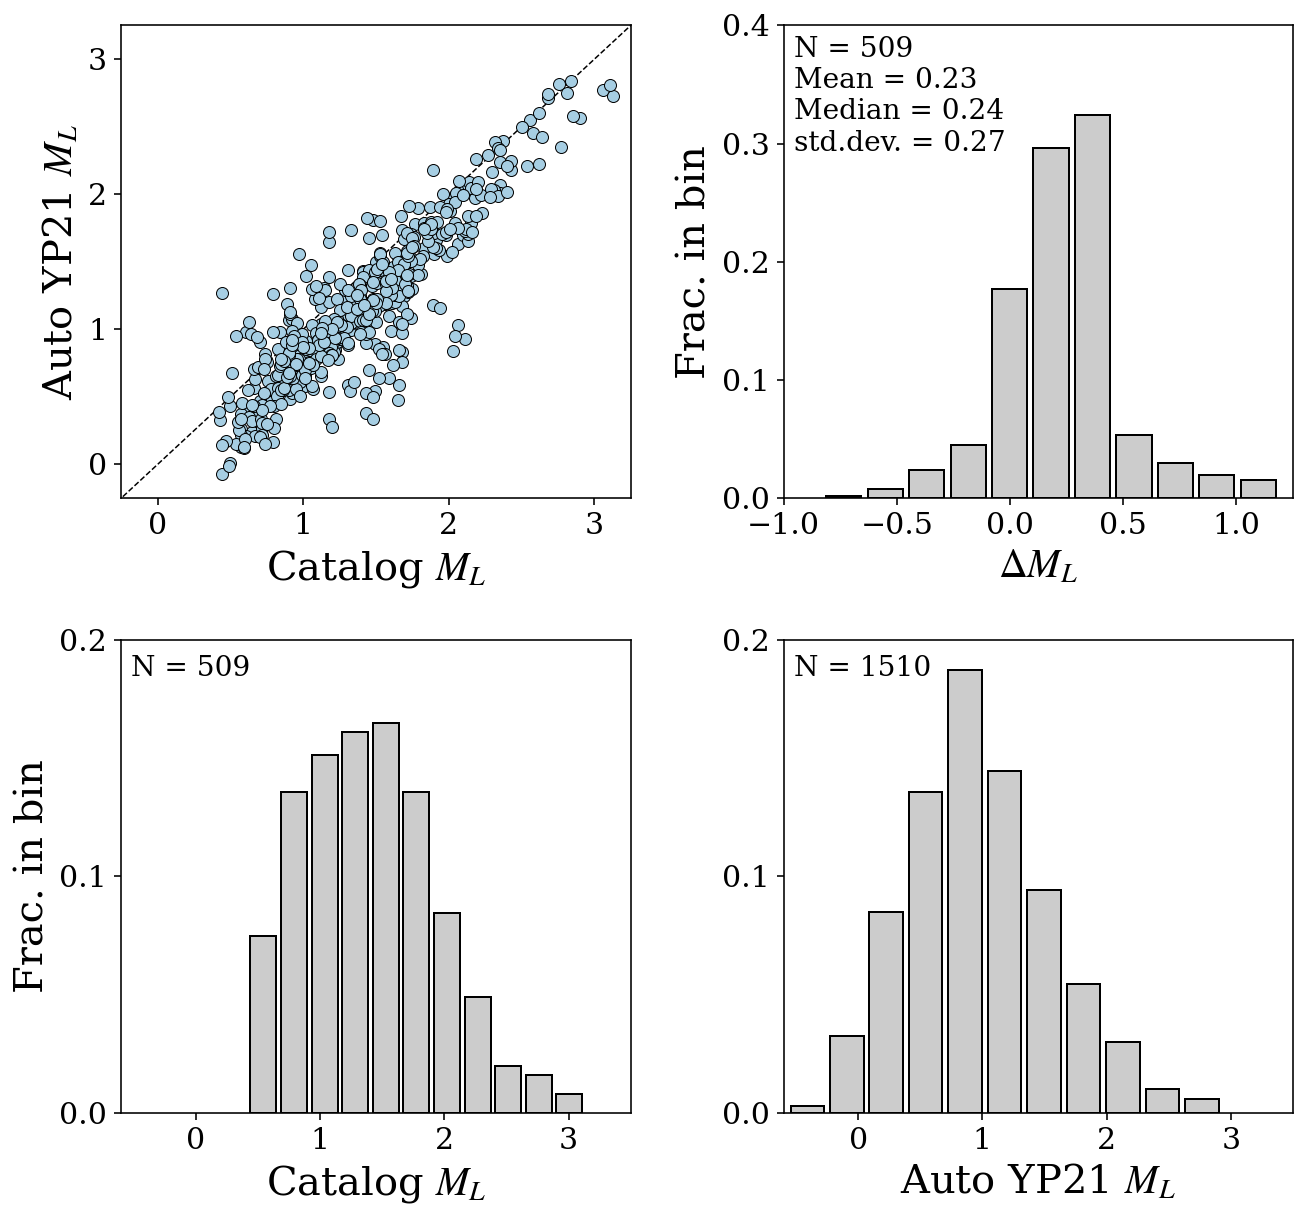

In [20]:
# Assign useful plot variables
# -------------------------------
lims = [-0.25, 3.25] # ML vs ML limits
na = (evmags["UUSS-ML"] != -9.99) & (evmags["UUSS-ML"] <= 3.5) # reduce to rows with catalog UUSS ML
luu = len(evmags["UUSS-ML"][na])  # how many UUSS ML
hkwargs = dict(
    bottom=0.0, 
    color='.8', 
    edgecolor='k', 
    rwidth=0.85,
    bins=11
)
fig, ax = plt.subplots(2, 2, figsize=(10.5, 10))
ax = ax.flatten()
for a in ax:
    a.tick_params(axis='both', labelsize=15)

# subplot 1 (top left) - YPML (auto) vs UUSS Catalog ML
ax[0].plot([-1, 5], [-1, 5], 'k--', lw=0.75)
ax[0].plot(
    evmags["UUSS-ML"][na].values, 
    evmags["Event-YPML-S"][na].values, 
    'o',
    color='#a6cee3',
    mec='k',
    mew='0.5'
)
# subplot styling
ax[0].set(xlim=lims, ylim=lims)
ax[0].yaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].set(xlabel=r"Catalog $M_L$", ylabel=r"Auto YP21 $M_L$")

# subplot 2 (top right) - UUSS ML minus YPML (auto) as histogram
# useful numbers and arrays
diffs = evmags["UUSS-ML"][na].values - evmags["Event-YPML-S"][na].values
mean_diffs = np.nanmean(diffs)
median_diffs = np.nanmedian(diffs)
std_diffs = np.nanstd(diffs)
# subplot 2 elements
ax[1].hist(
    diffs, 
    weights=np.zeros_like(diffs) + 1. / diffs.size,
    **hkwargs
)
ax[1].text(
    0.02, 
    0.85, 
    f"""N = {luu:d}\nMean = {mean_diffs:.2f}\nMedian = {median_diffs:.2f}\nstd.dev. = {std_diffs:.2f}""", 
    horizontalalignment='left', 
    verticalalignment='center', 
    transform=ax[1].transAxes,
    fontsize=14
)
# sublot 2 styling
_ = ax[1].set(xlim=[-1, 1.25], ylim=[0, 0.4], ylabel="Frac. in bin", xlabel=r"$\Delta M_L$")
_ = ax[1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
_ = ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))

# subplot 3 (bottom left) - UUSS ML minus YPML (auto) as histogram
_ = ax[2].set(ylabel="Frac. in bin")
labs = [r"Catalog $M_L$", r"Auto YP21 $M_L$"]
for i, ps in enumerate([evmags["UUSS-ML"][na], evmags["Event-YPML-S"]]):
    ax[i + 2].hist(
        ps.values, 
        weights=np.zeros_like(ps.values) + 1. / len(ps), 
        **hkwargs
    )
    ax[i + 2].text(
        0.02, 
        0.94, 
        f"N = {len(ps):d}", 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax[i + 2].transAxes,
        fontsize=14
    )
    # subplot 3 and 4 styling
    ax[i + 2].set(xlabel=labs[i], xlim=[-0.6, 3.5], ylim=[0, 0.2])
    ax[i + 2].xaxis.set_major_locator(plt.MultipleLocator(1))
    ax[i + 2].yaxis.set_major_locator(plt.MultipleLocator(0.1))
# general figure layout
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# save figure
fig.savefig(f"../figures/KOPER-AUTO-AMPS-COMP-{session.name}.pdf", bbox_inches="tight")